<a href="https://colab.research.google.com/github/reynaldovirtual/ProjetoRegressaoLinearT3/blob/main/RegressaoLinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Configuração do ambiente e importação das bibliotecas.**

In [32]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score, accuracy_score, confusion_matrix, mean_absolute_error, r2_score

import seaborn as sns
sns.set(style='whitegrid')

**Carregamento e visualização inicial dos dados.**

In [33]:
import pandas as pd
import kagglehub
import json
import os

# Baixando a versão mais recente
path = kagglehub.dataset_download("surajjha101/top-instagram-influencers-data-cleaned")

# Encontre o arquivo CSV no diretório baixado - ele pode estar em uma subpasta ou ter um nome diferente
for root, _, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            break
    else:
        continue
    break  # Saia do loop externo assim que o CSV for encontrado

# Se nenhum arquivo CSV for encontrado, gere um erro
if not file_path:
    raise FileNotFoundError("CSV file not found in the downloaded dataset.")

# Leia o CSV com tratamento de erros para linhas problemáticas
try:
    # Substitua 'error_bad_lines=False' por 'on_bad_lines='skip''
    data = pd.read_csv(file_path, on_bad_lines='skip')
except pd.errors.ParserError:
    # Se ocorrer ParserError, leia o arquivo linha por linha e manipule channel_info
    data = []
    with open(file_path, 'r') as file:  # Use file_path aqui também
        for line in file:
            try:
                # Tente dividir a linha por vírgulas
                fields = line.strip().split(',')
                # Se channel_info for um JSON válido, analise-o
                if fields[1].startswith('{') and fields[1].endswith('}'):
                    fields[1] = json.loads(fields[1])
                data.append(fields)
            except (json.JSONDecodeError, IndexError):
                # Pular linhas com channel_info inválido ou campos ausentes
                print(f"Skipping line: {line.strip()}")
                pass

    # Crie o DataFrame a partir dos dados processados
    data = pd.DataFrame(data, columns=['rank', 'channel_info', 'influence_score', 'posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes', 'country'])

print(data.head())

   rank channel_info  influence_score  posts followers avg_likes  \
0     1    cristiano               92   3.3k    475.8m      8.7m   
1     2  kyliejenner               91   6.9k    366.2m      8.3m   
2     3     leomessi               90  0.89k    357.3m      6.8m   
3     4  selenagomez               93   1.8k    342.7m      6.2m   
4     5      therock               91   6.8k    334.1m      1.9m   

  60_day_eng_rate new_post_avg_like total_likes        country  
0           1.39%              6.5m       29.0b          Spain  
1           1.62%              5.9m       57.4b  United States  
2           1.24%              4.4m        6.0b            NaN  
3           0.97%              3.3m       11.5b  United States  
4           0.20%            665.3k       12.5b  United States  



**Análise exploratória dos dados.**


In [34]:
# Função para converter notações 'k', 'm', 'b' em valores numéricos
def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.lower().replace(',', '')
        if 'k' in value:
            return float(value.replace('k', '')) * 1e3
        elif 'm' in value:
            return float(value.replace('m', '')) * 1e6
        elif 'b' in value:
            return float(value.replace('b', '')) * 1e9
        elif '%' in value:
            return float(value.replace('%', '')) / 100
    try:
        return float(value)
    except ValueError:
        return None

# Supondo que 'data' seja o seu DataFrame, renomeie-o para 'df'
df = data

# Aplique a conversão às colunas relevantes
columns_to_convert = ['posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes']
for col in columns_to_convert:
    df[col] = df[col].apply(convert_to_numeric)

# Verifique se há nulos e trate-os (para simplificar, elimine as linhas com nulos por enquanto)
df = df.dropna()

# Exibir as informações atualizadas do conjunto de dados e visualizar os dados limpos
df_info_cleaned = df.info()
df_head_cleaned = df.head()

df_info_cleaned, df_head_cleaned

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               138 non-null    int64  
 1   channel_info       138 non-null    object 
 2   influence_score    138 non-null    int64  
 3   posts              138 non-null    float64
 4   followers          138 non-null    float64
 5   avg_likes          138 non-null    float64
 6   60_day_eng_rate    138 non-null    float64
 7   new_post_avg_like  138 non-null    float64
 8   total_likes        138 non-null    float64
 9   country            138 non-null    object 
dtypes: float64(6), int64(2), object(2)
memory usage: 11.9+ KB


(None,
    rank   channel_info  influence_score   posts    followers  avg_likes  \
 0     1      cristiano               92  3300.0  475800000.0  8700000.0   
 1     2    kyliejenner               91  6900.0  366200000.0  8300000.0   
 3     4    selenagomez               93  1800.0  342700000.0  6200000.0   
 4     5        therock               91  6800.0  334100000.0  1900000.0   
 5     6  kimkardashian               91  5600.0  329200000.0  3500000.0   
 
    60_day_eng_rate  new_post_avg_like   total_likes        country  
 0           0.0139          6500000.0  2.900000e+10          Spain  
 1           0.0162          5900000.0  5.740000e+10  United States  
 3           0.0097          3300000.0  1.150000e+10  United States  
 4           0.0020           665300.0  1.250000e+10  United States  
 5           0.0088          2900000.0  1.990000e+10  United States  )


**Limpeza e Pré processamento dos Dados.**

In [35]:
# Função para converter notações 'k', 'm', 'b' em valores numéricos
def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.lower().replace(',', '')
        if 'k' in value:
            return float(value.replace('k', '')) * 1e3
        elif 'm' in value:
            return float(value.replace('m', '')) * 1e6
        elif 'b' in value:
            return float(value.replace('b', '')) * 1e9
        elif '%' in value:
            return float(value.replace('%', '')) / 100
    try:
        return float(value)
    except ValueError:
        return None

# Aplique a conversão às colunas relevantes
columns_to_convert = ['posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes']
for col in columns_to_convert:
    df[col] = df[col].apply(convert_to_numeric)

# Verifique se há nulos e trate-os (para simplificar, elimine as linhas com nulos por enquanto)
df = df.dropna()

# Exibir as informações atualizadas do conjunto de dados e visualizar os dados limpos
df_info_cleaned = df.info()
df_head_cleaned = df.head()

df_info_cleaned, df_head_cleaned


<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               138 non-null    int64  
 1   channel_info       138 non-null    object 
 2   influence_score    138 non-null    int64  
 3   posts              138 non-null    float64
 4   followers          138 non-null    float64
 5   avg_likes          138 non-null    float64
 6   60_day_eng_rate    138 non-null    float64
 7   new_post_avg_like  138 non-null    float64
 8   total_likes        138 non-null    float64
 9   country            138 non-null    object 
dtypes: float64(6), int64(2), object(2)
memory usage: 11.9+ KB


<ipython-input-35-7334b137a031>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(convert_to_numeric)


(None,
    rank   channel_info  influence_score   posts    followers  avg_likes  \
 0     1      cristiano               92  3300.0  475800000.0  8700000.0   
 1     2    kyliejenner               91  6900.0  366200000.0  8300000.0   
 3     4    selenagomez               93  1800.0  342700000.0  6200000.0   
 4     5        therock               91  6800.0  334100000.0  1900000.0   
 5     6  kimkardashian               91  5600.0  329200000.0  3500000.0   
 
    60_day_eng_rate  new_post_avg_like   total_likes        country  
 0           0.0139          6500000.0  2.900000e+10          Spain  
 1           0.0162          5900000.0  5.740000e+10  United States  
 3           0.0097          3300000.0  1.150000e+10  United States  
 4           0.0020           665300.0  1.250000e+10  United States  
 5           0.0088          2900000.0  1.990000e+10  United States  )

**Exibir estatísticas descritivas das variáveis numéricas.**

In [36]:
# Exibir estatísticas descritivas das variáveis numéricas
data.describe()


,rank,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes
count,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,199.000000,2.000000e+02,2.000000e+02
mean,100.500000,81.820000,3499.850000,7.740950e+07,1.787104e+06,0.019020,1.208132e+06,3.658112e+09
std,57.879185,8.878159,3475.828158,7.368727e+07,2.193359e+06,0.033297,1.858322e+06,5.561939e+09
min,1.000000,22.000000,10.000000,3.280000e+07,6.510000e+04,0.000100,0.000000e+00,1.830000e+07
25%,50.750000,80.000000,947.500000,4.000000e+07,5.044000e+05,0.004100,1.957500e+05,9.968500e+08
50%,100.500000,84.000000,2100.000000,5.005000e+07,1.100000e+06,0.008800,5.321500e+05,2.000000e+09
75%,150.250000,86.000000,5025.000000,6.890000e+07,2.100000e+06,0.020350,1.325000e+06,3.900000e+09
max,200.000000,93.000000,17500.000000,4.758000e+08,1.540000e+07,0.264100,1.260000e+07,5.740000e+10



**Análise exploratória dos dados.**

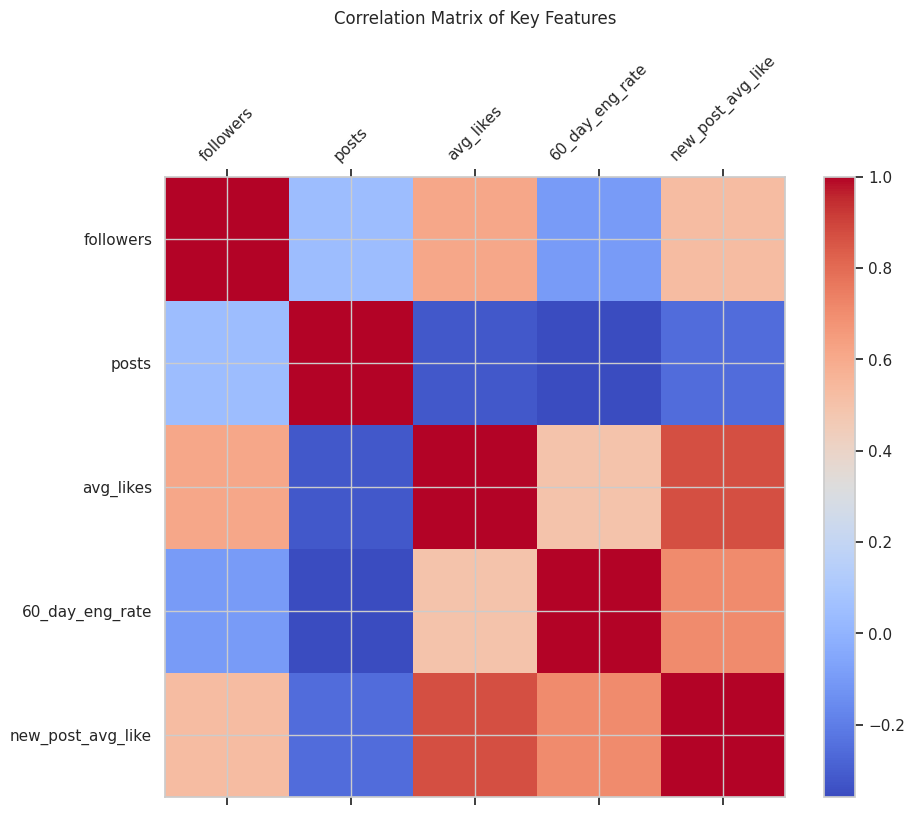

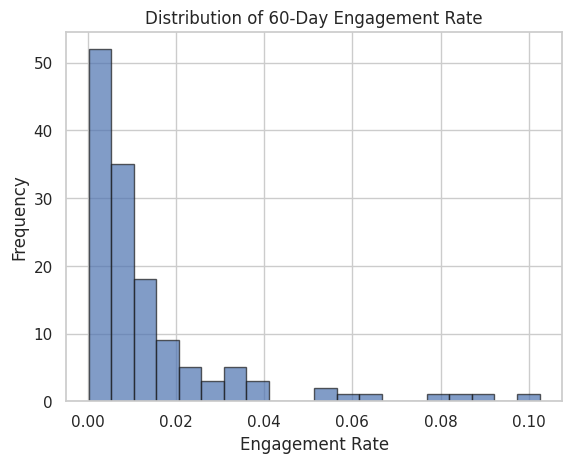

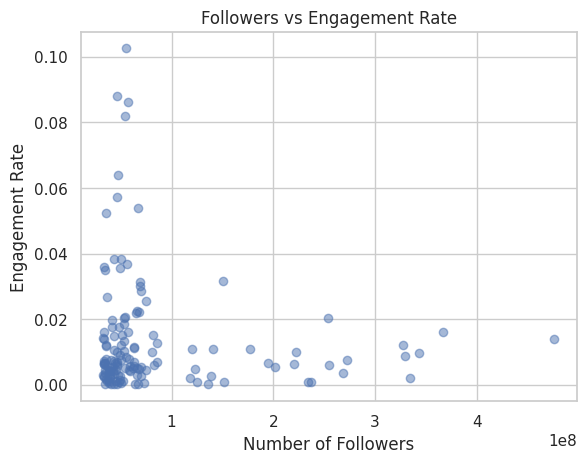

In [37]:
import matplotlib.pyplot as plt

# Matriz de correlação para entender as relações entre variáveis
correlation_matrix = df[['followers', 'posts', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like']].corr()

# Trace a matriz de correlação
plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.title("Correlation Matrix of Key Features", pad=20)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

# Visualizando a distribuição da variável alvo (taxa de engajamento)
plt.hist(df['60_day_eng_rate'], bins=20, edgecolor='k', alpha=0.7)
plt.title("Distribution of 60-Day Engagement Rate")
plt.xlabel("Engagement Rate")
plt.ylabel("Frequency")
plt.show()

# Gráfico de dispersão de seguidores versus taxa de engajamento
plt.scatter(df['followers'], df['60_day_eng_rate'], alpha=0.5)
plt.title("Followers vs Engagement Rate")
plt.xlabel("Number of Followers")
plt.ylabel("Engagement Rate")
plt.show()


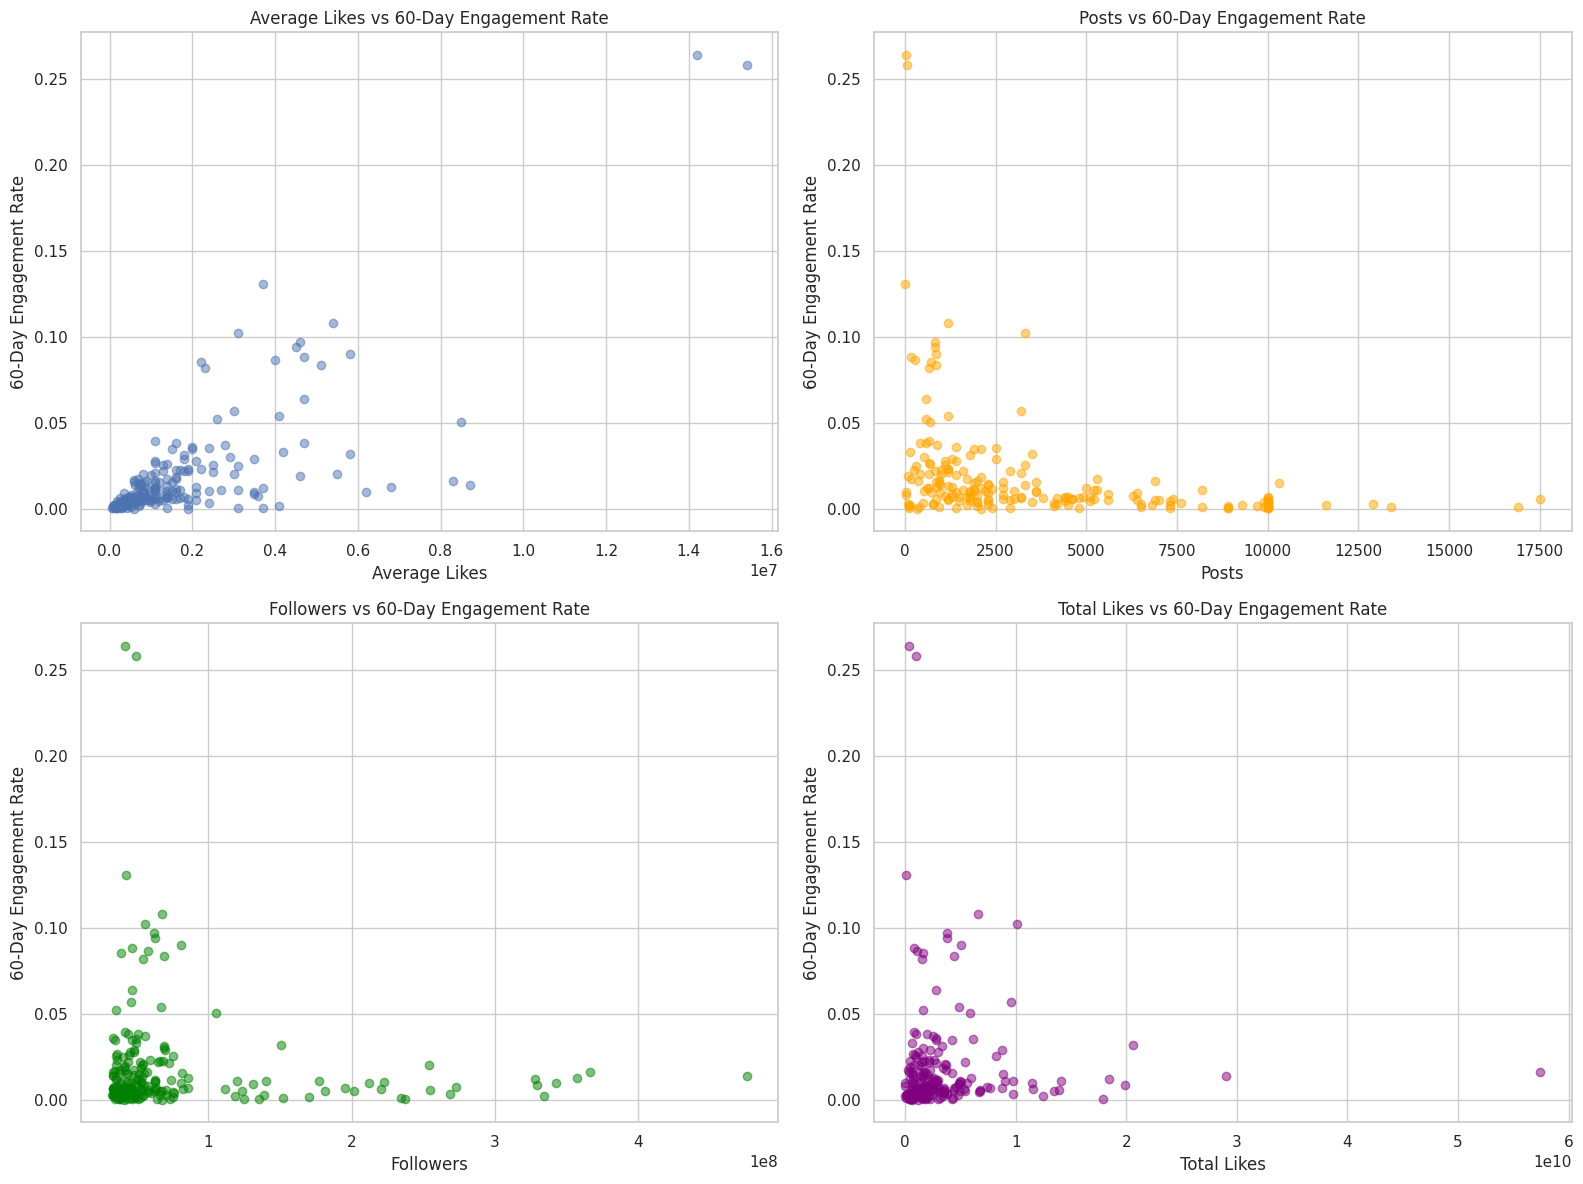

In [38]:
import matplotlib.pyplot as plt

# Configurar o tamanho da figura
plt.figure(figsize=(16, 12))

# Gráfico de dispersão para 'avg_likes' vs '60_day_eng_rate'
plt.subplot(2, 2, 1)
plt.scatter(data['avg_likes'], data['60_day_eng_rate'], alpha=0.5)
plt.xlabel('Average Likes')
plt.ylabel('60-Day Engagement Rate')
plt.title('Average Likes vs 60-Day Engagement Rate')

# Gráfico de dispersão para 'posts' vs '60_day_eng_rate'
plt.subplot(2, 2, 2)
plt.scatter(data['posts'], data['60_day_eng_rate'], alpha=0.5, color='orange')
plt.xlabel('Posts')
plt.ylabel('60-Day Engagement Rate')
plt.title('Posts vs 60-Day Engagement Rate')

# Gráfico de dispersão para 'followers' vs '60_day_eng_rate'
plt.subplot(2, 2, 3)
plt.scatter(data['followers'], data['60_day_eng_rate'], alpha=0.5, color='green')
plt.xlabel('Followers')
plt.ylabel('60-Day Engagement Rate')
plt.title('Followers vs 60-Day Engagement Rate')

# Gráfico de dispersão para 'total_likes' vs '60_day_eng_rate'
plt.subplot(2, 2, 4)
plt.scatter(data['total_likes'], data['60_day_eng_rate'], alpha=0.5, color='purple')
plt.xlabel('Total Likes')
plt.ylabel('60-Day Engagement Rate')
plt.title('Total Likes vs 60-Day Engagement Rate')

# Ajustar o layout e exibir os gráficos
plt.tight_layout()
plt.show()



**Divisão dos dados em conjuntos de treino e teste.**

In [39]:
from sklearn.model_selection import train_test_split

#  Definindo o conjunto de recursos (x) e a variável de destino (y)
X = df[['followers', 'posts', 'avg_likes', 'new_post_avg_like']]
y = df['60_day_eng_rate']

# Dividir os dados em conjuntos de treinamento e teste (80% treinamento, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibir as formas dos conjuntos de dados resultantes
X_train_shape = X_train.shape
X_test_shape = X_test.shape
y_train_shape = y_train.shape
y_test_shape = y_test.shape

X_train_shape, X_test_shape, y_train_shape, y_test_shape


((110, 4), (28, 4), (110,), (28,))


**Implementação do modelo de Regressão Linear.**

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Inicializar o modelo de Regressão Linear
model = LinearRegression()

# Treine o modelo no conjunto de treinamento
model.fit(X_train, y_train)

# Faça previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avalie o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

model_coefficients = model.coef_
model_intercept = model.intercept_

mse, r2, model_coefficients, model_intercept


(6.094692191871947e-05,
 0.8192946915672696,
 array([-1.21858286e-10, -5.03166108e-07, -2.29949453e-09,  1.53590749e-08]),
 0.014470648363795097)

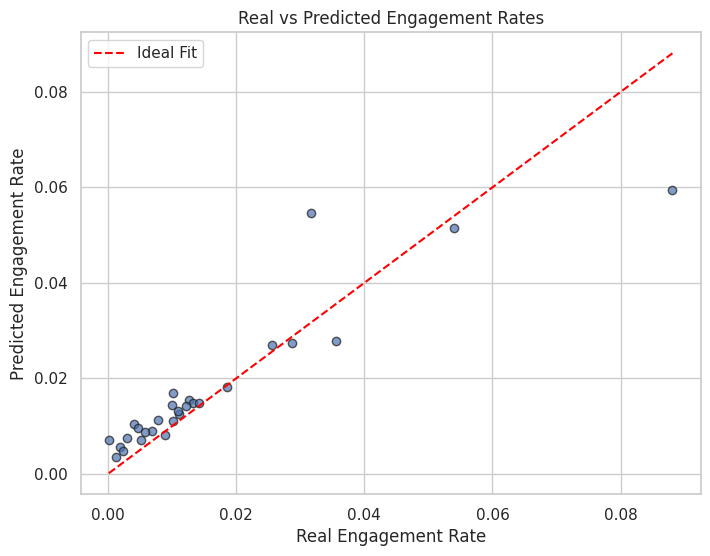

In [25]:
# Traçando taxas de engajamento reais versus previstas
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Ideal Fit")
plt.title("Real vs Predicted Engagement Rates")
plt.xlabel("Real Engagement Rate")
plt.ylabel("Predicted Engagement Rate")
plt.legend()
plt.grid(True)
plt.show()


**Aplicando o gradiente descendente.**

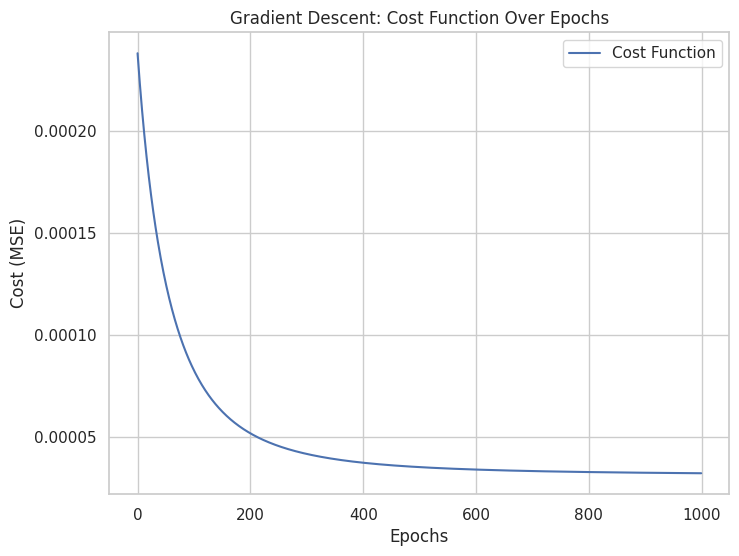

(array([-0.01037423, -0.00146082, -0.00092371,  0.01806605]),
 0.013678206490975096)

In [26]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Normalize os recursos usando StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Re-dividir os dados normalizados em conjuntos de treinamento e teste
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Implementação de descida de Gradiente
def gradient_descent(X, y, alpha=0.01, epochs=1000):
    m, n = X.shape
    theta = np.zeros(n)  # Inicializar parâmetros
    bias = 0  # Iniciar termo de viés
    costs = []  # Para armazenar o custo em cada época

    for _ in range(epochs):
        # Calcular previsões
        y_pred = np.dot(X, theta) + bias

        # Calcular gradientes
        error = y_pred - y
        d_theta = (1 / m) * np.dot(X.T, error)
        d_bias = (1 / m) * np.sum(error)

        # Atualizar parâmetros
        theta -= alpha * d_theta
        bias -= alpha * d_bias

        # Custo de computação (MSE)
        cost = (1 / (2 * m)) * np.sum(error ** 2)
        costs.append(cost)

    return theta, bias, costs

# Aplicar gradiente descendente
theta, bias, costs = gradient_descent(X_train_scaled, y_train.values, alpha=0.01, epochs=1000)

# Trace a função de custo ao longo das épocas
plt.figure(figsize=(8, 6))
plt.plot(range(1000), costs, label="Cost Function")
plt.title("Gradient Descent: Cost Function Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Cost (MSE)")
plt.legend()
plt.grid(True)
plt.show()

theta, bias


**Regularização Ridge e Lasso.**

In [27]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

# Ridge (Regularização L2)
ridge_model = Ridge(alpha=1.0)  # Alpha é a força de regularização
ridge_scores = cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Lasso (Regularização L1)
lasso_model = Lasso(alpha=0.01)  # Alpha é a força de regularização
lasso_scores = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Pontuações médias R² da validação cruzada
ridge_mean_r2 = np.mean(ridge_scores)
lasso_mean_r2 = np.mean(lasso_scores)

ridge_mean_r2, lasso_mean_r2


(0.7075994597915878, 0.13198924957698244)

**Ajustando alfa para Lasso para melhorar o desempenho.**

In [28]:
# Ajustando alfa para Lasso para melhorar o desempenho
lasso_alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
lasso_r2_scores = []

for alpha in lasso_alphas:
    lasso_model = Lasso(alpha=alpha)
    scores = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5, scoring='r2')
    lasso_r2_scores.append(np.mean(scores))

# Identifique o melhor alfa para Lasso
best_lasso_alpha = lasso_alphas[np.argmax(lasso_r2_scores)]
best_lasso_r2 = max(lasso_r2_scores)

# Treine e avalie Ridge, Lasso (melhor alfa) e a Regressão Linear básica
ridge_model = Ridge(alpha=1.0).fit(X_train_scaled, y_train)
lasso_model = Lasso(alpha=best_lasso_alpha).fit(X_train_scaled, y_train)
simple_model = LinearRegression().fit(X_train_scaled, y_train)

# Prever no conjunto de teste
ridge_pred = ridge_model.predict(X_test_scaled)
lasso_pred = lasso_model.predict(X_test_scaled)
simple_pred = simple_model.predict(X_test_scaled)

# Calculae R² e MSE para cada modelo
ridge_r2_test = r2_score(y_test, ridge_pred)
lasso_r2_test = r2_score(y_test, lasso_pred)
simple_r2_test = r2_score(y_test, simple_pred)

ridge_mse_test = mean_squared_error(y_test, ridge_pred)
lasso_mse_test = mean_squared_error(y_test, lasso_pred)
simple_mse_test = mean_squared_error(y_test, simple_pred)

best_lasso_alpha, best_lasso_r2, ridge_r2_test, lasso_r2_test, simple_r2_test, ridge_mse_test, lasso_mse_test, simple_mse_test


(0.001,
 0.7065332926956331,
 0.8177257286913113,
 0.8000789613442972,
 0.81929469156727,
 6.147608987025198e-05,
 6.742785830995252e-05,
 6.0946921918719367e-05)

**Visualizando o melhor modelo (Regressão Linear Simples).**

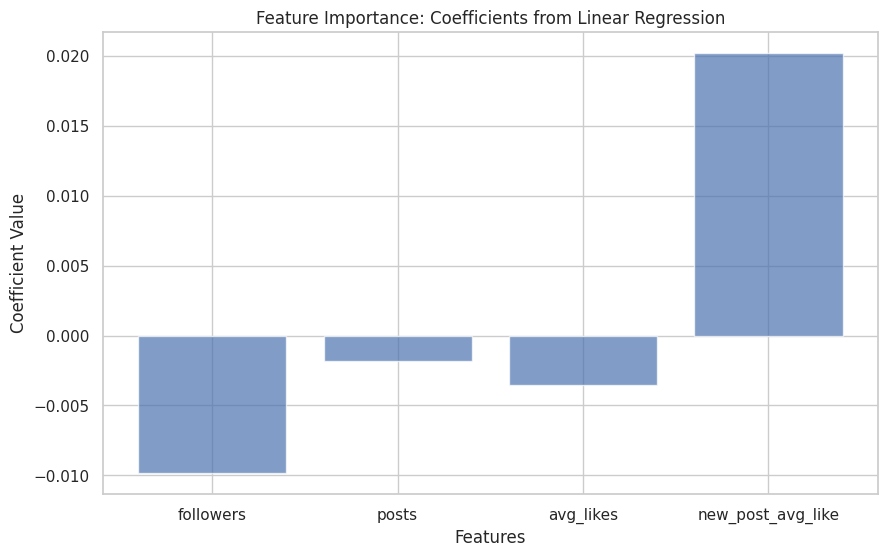

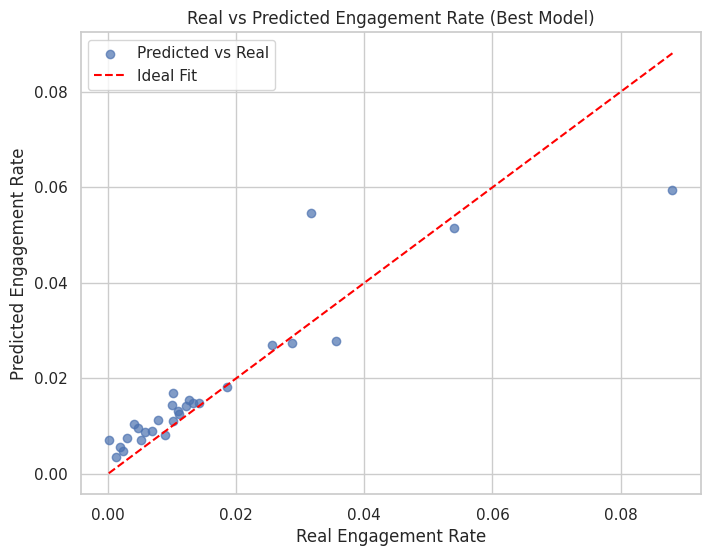

In [41]:

import pandas as pd
from sklearn.metrics import mean_absolute_error

# Calcular métricas adicionais: MAE
ridge_mae_test = mean_absolute_error(y_test, ridge_pred)
lasso_mae_test = mean_absolute_error(y_test, lasso_pred)
simple_mae_test = mean_absolute_error(y_test, simple_pred)

# Interpretação dos coeficientes para o modelo de melhor desempenho (Regressão Linear Simples)
simple_model_coefficients = simple_model.coef_
simple_model_features = X.columns

# Visualizando coeficientes
plt.figure(figsize=(10, 6))
plt.bar(simple_model_features, simple_model_coefficients, alpha=0.7)
plt.title("Feature Importance: Coefficients from Linear Regression")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.grid(True)
plt.show()

# Visualizando previsões vs resultados reais para o melhor modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_test, simple_pred, alpha=0.7, label="Predicted vs Real")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Ideal Fit")
plt.title("Real vs Predicted Engagement Rate (Best Model)")
plt.xlabel("Real Engagement Rate")
plt.ylabel("Predicted Engagement Rate")
plt.legend()
plt.grid(True)
plt.show()